In [1]:
!aws s3 cp s3://retrainoutput/SpotBot-2022-06-06-02-17-08/output/model.tar.gz ./

download: s3://retrainoutput/SpotBot-2022-06-06-02-17-08/output/model.tar.gz to ./model.tar.gz


In [8]:
!tar -xzvf model.tar.gz
!mv visualsearch/weights/best.pt ./

visualsearch/
visualsearch/hyp.yaml
visualsearch/val_batch1_pred.jpg
visualsearch/events.out.tfevents.1654482086.ip-10-0-254-43.ap-southeast-1.compute.internal.31.0
visualsearch/train_batch0.jpg
visualsearch/labels.jpg
visualsearch/val_batch0_pred.jpg
visualsearch/val_batch2_pred.jpg
visualsearch/opt.yaml
visualsearch/P_curve.png
visualsearch/results.png
visualsearch/R_curve.png
visualsearch/F1_curve.png
visualsearch/train_batch1.jpg
visualsearch/confusion_matrix.png
visualsearch/train_batch2.jpg
visualsearch/val_batch2_labels.jpg
visualsearch/val_batch1_labels.jpg
visualsearch/weights/
visualsearch/weights/last.pt
visualsearch/weights/best.pt
visualsearch/PR_curve.png
visualsearch/results.csv
visualsearch/val_batch0_labels.jpg
visualsearch/labels_correlogram.jpg


In [4]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 12173, done.
remote: Total 12173 (delta 0), reused 0 (delta 0), pack-reused 12173
Receiving objects: 100% (12173/12173), 11.90 MiB | 16.65 MiB/s, done.
Resolving deltas: 100% (8429/8429), done.


In [10]:
!mv yolov5/utils ./
!mv yolov5/models ./


mv: cannot stat ‘yolov5/utils’: No such file or directory


In [6]:
import torch
import cv2
import numpy as np

import utils
from utils.general import non_max_suppression
#from utils.utils import non_max_suppression, attempt_download
#!python detect.py --weights best.pt --img 640 --conf 0.25 --source data/images

In [11]:
weights='best.pt'
image='test/images/w1240-p16x9-0e48e0098f6e832f27d8b581b33bbc72b9967a63_jpg.rf.34ed1e8f70eebdabaf43ab9d40dc1c9b.jpg'
output_dir='output/'
thres=0.4

classnames = ['mask', 'unmask']


label = {}
for i, name in enumerate(classnames):
    label[i]=name

model = torch.load(weights)
#model.eval()
#model = torch.hub.load('home/yolov5', 'custom', path=weights)
print("########")
# load pre-trained model
#weights = opt.weights
#attempt_download(weights)

# try:
model = torch.load(weights)['model'].float()
model.eval()
# except:
#     print('[ERROR] check the model')


def image_loader(img,imsize):
    '''
    processes input image for inference 
    '''
    h, w = img.shape[:2]
    img = cv2.resize(img,(imsize,imsize))
    img = img[:, :, ::-1].transpose(2, 0, 1) 
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img)
    img = img.float()
    img /= 255.0
    img = img.unsqueeze(0)
    return img, h, w 


def get_pred(img):
    '''
    returns prediction in numpy array
    '''
    imsize = 640
    img, h, w = image_loader(img,imsize)
    pred = model(img)[0]
    pred = non_max_suppression(pred, conf_thres=thres) # conf_thres is confidence thresold
    if pred[0] is not None:
        gain = imsize / max(h,w)
        pad = (imsize - w * gain) / 2, (imsize - h * gain) / 2  # wh padding
        pred = pred[0]

        pred[:, [0, 2]] -= pad[0]  # x padding
        pred[:, [1, 3]] -= pad[1]  # y padding
        pred[:, :4] /= gain
        pred[:, 0].clamp_(0, w)  # x1
        pred[:, 1].clamp_(0, h)  # y1
        pred[:, 2].clamp_(0, w)  # x2
        pred[:, 3].clamp_(0, h)  # y2

        pred = pred.detach().numpy()

    return pred
                

path = image

image = cv2.imread(path)

if image is not None:
    prediction = get_pred(image)

    if prediction is not None:
        for pred in prediction:

            x1 = int(pred[0])
            y1 = int(pred[1])
            x2 = int(pred[2])
            y2 = int(pred[3])

            start = (x1,y1)
            end = (x2,y2)

            pred_data = f'{label[pred[-1]]} {str(pred[-2]*100)[:5]}%'
            print(pred_data)
            color = (0,255,0)
            image = cv2.rectangle(image, start, end, color)
            image = cv2.putText(image, pred_data, (x1,y1+25), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA) 
        cv2.imwrite('result.jpg', image)
        #cv2.imshow('output',image)

else:
    print('[ERROR] check input image')
    


########
mask 40.38%


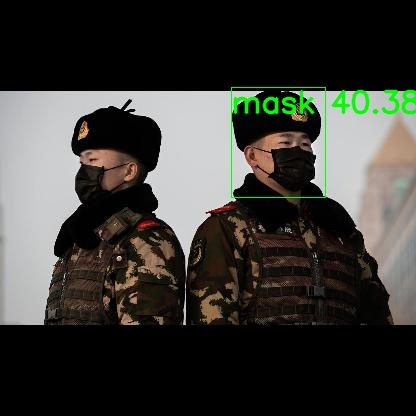

In [12]:
from IPython.display import Image
Image(filename='result.jpg') 